# 1. Setup


In [52]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Define the TrialSequence class
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.switch_weights = None
        self.censor_weights = None
        self.expansion_options = None
        self.expansion = None
        self.outcome_formula = None
        self.outcome_model = None

    def __str__(self):
        summary = f"Trial Sequence Object\nEstimand: {self.estimand}\n\n"
        
        # Data section
        if self.data is not None:
            n_obs = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            summary += f"Data:\n - N: {n_obs} observations from {n_patients} patients\n"
            summary += f"{self.data.head(6).to_string(index=False)}\n"
        else:
            summary += "Data: Not set\n"
        
        # Switch weights section
        if self.switch_weights:
            summary += f"IPW for treatment switching:\n"
            summary += f" - Numerator: {self.switch_weights['numerator']}\n"
            summary += f" - Denominator: {self.switch_weights['denominator']}\n"
        else:
            summary += "IPW for treatment switching: Not set\n"
        
        # Censor weights section
        if self.censor_weights:
            summary += f"IPW for informative censoring:\n"
            summary += f" - Numerator: {self.censor_weights['numerator']}\n"
            summary += f" - Denominator: {self.censor_weights['denominator']}\n"
        else:
            summary += "IPW for informative censoring: Not set\n"
        
        # Expansion options section
        if self.expansion_options:
            summary += f"Sequence of Trials Data:\n"
            summary += f" - Chunk size: {self.expansion_options['chunk_size']}\n"
        else:
            summary += "Sequence of Trials Data: Not set\n"
        
        # Outcome model section
        if self.outcome_formula:
            summary += f"Outcome model:\n - Formula: {self.outcome_formula}\n"
        else:
            summary += "Outcome model: Not set\n"
        
        return summary

# Initialize trial sequence objects
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# Create temporary directories
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# 2.Data Prep


In [53]:
# Define the set_data function
def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    trial.data = data
    trial.id_col = id_col
    trial.period_col = period_col
    trial.treatment_col = treatment_col
    trial.outcome_col = outcome_col
    trial.eligible_col = eligible_col
    return trial

# Load dummy data
data_censored = pd.read_csv("data_censored.csv")

# Set data for both trials
trial_pp = set_data(trial_pp, data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt = set_data(trial_itt, data_censored, "id", "period", "treatment", "outcome", "eligible")

# Optional: Print the trial objects to verify
print(trial_pp)
print(trial_itt)

Trial Sequence Object
Estimand: PP

Data:
 - N: 725 observations from 89 patients
 id  period  treatment  x1        x2  x3       x4  age    age_s  outcome  censored  eligible
  1       0          1   1  1.146148   0 0.734203   36 0.083333        0         0         1
  1       1          1   1  0.002200   0 0.734203   37 0.166667        0         0         0
  1       2          1   0 -0.481762   0 0.734203   38 0.250000        0         0         0
  1       3          1   0  0.007872   0 0.734203   39 0.333333        0         0         0
  1       4          1   1  0.216054   0 0.734203   40 0.416667        0         0         0
  1       5          1   0 -0.057482   0 0.734203   41 0.500000        0         1         0
IPW for treatment switching: Not set
IPW for informative censoring: Not set
Sequence of Trials Data: Not set
Outcome model: Not set

Trial Sequence Object
Estimand: ITT

Data:
 - N: 725 observations from 89 patients
 id  period  treatment  x1        x2  x3       x4  

# 3.1 Censoring 


In [54]:
def set_switch_weight_model(trial, numerator, denominator, save_path, model_fitter="statsmodels_logit"):
    """
    Sets the switch weight model parameters and displays the summary.

    Parameters:
    - trial: TrialSequence object
    - numerator: str, formula for the numerator model
    - denominator: str, formula for the denominator model
    - save_path: str, path to save the models
    - model_fitter: str, optional, type of model fitter (default: "statsmodels_logit")

    Returns:
    - trial: Updated TrialSequence object
    """
    # Set the switch weights parameters
    trial.switch_weights = {
        "numerator": numerator,
        "denominator": denominator,
        "save_path": save_path,
        "model_fitter": model_fitter
    }
    
    # Display the switch weights summary
    print("Switch Weights Summary:")
    print(f" - Numerator formula: {numerator}")
    print(f" - Denominator formula: {denominator}")
    print(f" - Model fitter type: {model_fitter}")
    print(f" - Save path: {save_path}")
    print(" - Weight models not fitted. Use calculate_weights() to fit the models.")
    
    return trial

# Example usage
import os

trial_pp_dir = "path/to/your/directory"  
trial_pp = set_switch_weight_model(
    trial_pp,
    numerator="treatment ~ age",
    denominator="treatment ~ age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models"),
    model_fitter="statsmodels_logit"  # Optional: matches your intended model fitter
)

Switch Weights Summary:
 - Numerator formula: treatment ~ age
 - Denominator formula: treatment ~ age + x1 + x3
 - Model fitter type: statsmodels_logit
 - Save path: path/to/your/directory\switch_models
 - Weight models not fitted. Use calculate_weights() to fit the models.


# 3.2 Other informative censoring

In [55]:
def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path, model_fitter="statsmodels_logit"):
    """
    Sets the censor weight model parameters and displays the summary.

    Parameters:
    - trial: TrialSequence object
    - censor_event: str, column name for the censoring indicator
    - numerator: str, formula for the numerator model
    - denominator: str, formula for the denominator model
    - pool_models: str, pooling strategy for the models (e.g., "none", "numerator")
    - save_path: str, path to save the models
    - model_fitter: str, optional, type of model fitter (default: "statsmodels_logit")

    Returns:
    - trial: Updated TrialSequence object
    """
    # Set the censor weights parameters
    trial.censor_weights = {
        "censor_event": censor_event,
        "numerator": numerator,
        "denominator": denominator,
        "pool_models": pool_models,
        "save_path": save_path,
        "model_fitter": model_fitter
    }
    
    # Display the censor weights summary
    print("Censor Weights Summary:")
    print(f" - Numerator formula: {numerator}")
    print(f" - Denominator formula: {denominator}")
    
    # Display pooling information based on pool_models
    if pool_models == "none":
        print(" - No pooling for numerator or denominator models.")
    elif pool_models == "numerator":
        print(" - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    else:
        print(f" - Pooling strategy: {pool_models}")
    
    print(f" - Model fitter type: {model_fitter}")
    print(" - Weight models not fitted. Use calculate_weights() to fit the models.")
    
    return trial

# Example usage
import os

trial_pp_dir = "path/to/your/directory"  
trial_itt_dir = "path/to/your/directory" 

trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator="1 - censored ~ x2",
    denominator="1 - censored ~ x2 + x1",
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "censor_models"),
    model_fitter="statsmodels_logit"
)

trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="1 - censored ~ x2",
    denominator="1 - censored ~ x2 + x1",
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "censor_models"),
    model_fitter="statsmodels_logit"
)

Censor Weights Summary:
 - Numerator formula: 1 - censored ~ x2
 - Denominator formula: 1 - censored ~ x2 + x1
 - No pooling for numerator or denominator models.
 - Model fitter type: statsmodels_logit
 - Weight models not fitted. Use calculate_weights() to fit the models.
Censor Weights Summary:
 - Numerator formula: 1 - censored ~ x2
 - Denominator formula: 1 - censored ~ x2 + x1
 - Numerator model is pooled across treatment arms. Denominator model is not pooled.
 - Model fitter type: statsmodels_logit
 - Weight models not fitted. Use calculate_weights() to fit the models.


# 4. Weight Calculation

In [56]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
import os

def fit_logit_with_separation_handling(formula, data):
    """
    Fits a logistic regression model and handles perfect separation by falling back to an intercept-only model.
    
    Parameters:
    - formula (str): The model formula (e.g., 'treatment ~ age' or '1 - censored ~ x2').
    - data (pd.DataFrame): The data to fit the model on.
    
    Returns:
    - model: The fitted statsmodels logit model.
    """
    outcome_expr = formula.split("~")[0].strip()  # Extract outcome (e.g., 'treatment' or '1 - censored')
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        try:
            model = smf.logit(formula, data).fit(disp=0)  # Fit the original model
        except Exception as e:
            print(f"Error fitting model with formula '{formula}': {e}")
            model = smf.logit(f"{outcome_expr} ~ 1", data).fit(disp=0)  # Fallback to intercept-only
        if any(isinstance(x.message, PerfectSeparationWarning) for x in w):
            print(f"Perfect separation detected for formula '{formula}', using intercept-only model")
            model = smf.logit(f"{outcome_expr} ~ 1", data).fit(disp=0)  # Fallback to intercept-only
    return model

def calculate_weights(trial):
    data = trial.data.copy()
    weights = pd.Series(1.0, index=data.index)
    
    # Create directories if they don't exist
    if trial.switch_weights and 'save_path' in trial.switch_weights:
        os.makedirs(trial.switch_weights['save_path'], exist_ok=True)
    if trial.censor_weights and 'save_path' in trial.censor_weights:
        os.makedirs(trial.censor_weights['save_path'], exist_ok=True)
    
    # Initialize model storage
    trial.weight_models = {}
    
    # Switch weights (PP only)
    if trial.estimand == "PP" and trial.switch_weights:
        data["prev_treatment"] = data.groupby(trial.id_col)[trial.treatment_col].shift(1)
        for prev_trt in [0, 1]:
            subset = data[data["prev_treatment"] == prev_trt].dropna(subset=["prev_treatment"])
            if not subset.empty:
                # Fit numerator and denominator models
                num_model = fit_logit_with_separation_handling(trial.switch_weights["numerator"], subset)
                den_model = fit_logit_with_separation_handling(trial.switch_weights["denominator"], subset)
                
                # Predict probabilities and clip to avoid 0 or 1
                num_prob = np.clip(num_model.predict(subset), 1e-5, 1 - 1e-5)
                den_prob = np.clip(den_model.predict(subset), 1e-5, 1 - 1e-5)
                
                # Update weights
                weights.loc[subset.index] *= num_prob / den_prob
                
                # Save models
                num_path = os.path.join(trial.switch_weights["save_path"], f"num_{prev_trt}.pkl")
                den_path = os.path.join(trial.switch_weights["save_path"], f"den_{prev_trt}.pkl")
                with open(num_path, "wb") as f:
                    pickle.dump(num_model, f)
                with open(den_path, "wb") as f:
                    pickle.dump(den_model, f)
                
                # Store model information
                trial.weight_models[f"switch_num_{prev_trt}"] = {"model": num_model, "path": num_path}
                trial.weight_models[f"switch_den_{prev_trt}"] = {"model": den_model, "path": den_path}
    
    # Censor weights
    if trial.censor_weights:
        if trial.censor_weights["pool_models"] == "numerator":
            # Fit pooled numerator model
            num_model = fit_logit_with_separation_handling(trial.censor_weights["numerator"], data)
            num_prob = np.clip(num_model.predict(data), 1e-5, 1 - 1e-5)
            
            # Save numerator model
            num_path = os.path.join(trial.censor_weights["save_path"], "num.pkl")
            with open(num_path, "wb") as f:
                pickle.dump(num_model, f)
            trial.weight_models["censor_num"] = {"model": num_model, "path": num_path}
            
            for prev_trt in [0, 1]:
                subset = data[data[trial.treatment_col].shift(1) == prev_trt].dropna(subset=[trial.treatment_col])
                if not subset.empty:
                    # Fit denominator model
                    den_model = fit_logit_with_separation_handling(trial.censor_weights["denominator"], subset)
                    den_prob = np.clip(den_model.predict(subset), 1e-5, 1 - 1e-5)
                    
                    # Update weights
                    weights.loc[subset.index] *= num_prob.loc[subset.index] / den_prob
                    
                    # Save denominator model
                    den_path = os.path.join(trial.censor_weights["save_path"], f"den_{prev_trt}.pkl")
                    with open(den_path, "wb") as f:
                        pickle.dump(den_model, f)
                    trial.weight_models[f"censor_den_{prev_trt}"] = {"model": den_model, "path": den_path}
        else:
            for prev_trt in [0, 1]:
                subset = data[data[trial.treatment_col].shift(1) == prev_trt].dropna(subset=[trial.treatment_col])
                if not subset.empty:
                    # Fit numerator and denominator models
                    num_model = fit_logit_with_separation_handling(trial.censor_weights["numerator"], subset)
                    den_model = fit_logit_with_separation_handling(trial.censor_weights["denominator"], subset)
                    
                    # Predict probabilities and clip
                    num_prob = np.clip(num_model.predict(subset), 1e-5, 1 - 1e-5)
                    den_prob = np.clip(den_model.predict(subset), 1e-5, 1 - 1e-5)
                    
                    # Update weights
                    weights.loc[subset.index] *= num_prob / den_prob
                    
                    # Save models
                    num_path = os.path.join(trial.censor_weights["save_path"], f"num_{prev_trt}.pkl")
                    den_path = os.path.join(trial.censor_weights["save_path"], f"den_{prev_trt}.pkl")
                    with open(num_path, "wb") as f:
                        pickle.dump(num_model, f)
                    with open(den_path, "wb") as f:
                        pickle.dump(den_model, f)
                    trial.weight_models[f"censor_num_{prev_trt}"] = {"model": num_model, "path": num_path}
                    trial.weight_models[f"censor_den_{prev_trt}"] = {"model": den_model, "path": den_path}
    
    trial.data["weight"] = weights
    return trial

def show_weight_models(trial):
    """
    Displays summaries of the fitted weight models stored in the trial object.
    
    Parameters:
    - trial: The trial object containing weight_models dictionary.
    """
    if not hasattr(trial, 'weight_models') or not trial.weight_models:
        print("No weight models have been fitted yet.")
        return
    
    # Separate switch and censor models
    switch_models = {k: v for k, v in trial.weight_models.items() if "switch" in k}
    censor_models = {k: v for k, v in trial.weight_models.items() if "censor" in k}
    
    # Display censoring models
    if censor_models:
        print("Weight Models for Informative Censoring")
        print("---------------------------------------\n")
        for model_key, model_info in censor_models.items():
            model = model_info["model"]
            path = model_info["path"]
            
            # Determine numerator or denominator and previous treatment
            if "num" in model_key:
                formula_type = "numerator"
            elif "den" in model_key:
                formula_type = "denominator"
            
            prev_trt = model_key.split("_")[-1]
            if prev_trt.isdigit():
                prev_trt = int(prev_trt)
                model_description = f"P({trial.censor_weights['censor_event']} = 0 | X, previous treatment = {prev_trt}) for {formula_type}"
            else:
                model_description = f"P({trial.censor_weights['censor_event']} = 0 | X) for {formula_type}"
            
            print(f"Model: {model_description}")
            print(model.summary())
            print(f"Path: {path}\n")
    
    # Display switch models
    if switch_models:
        print("Weight Models for Treatment Switching")
        print("-------------------------------------\n")
        for model_key, model_info in switch_models.items():
            model = model_info["model"]
            path = model_info["path"]
            
            if "num" in model_key:
                formula_type = "numerator"
            elif "den" in model_key:
                formula_type = "denominator"
            
            prev_trt = int(model_key.split("_")[-1])
            model_description = f"P({trial.treatment_col} = 1 | previous treatment = {prev_trt}) for {formula_type}"
            
            print(f"Model: {model_description}")
            print(model.summary())
            print(f"Path: {path}\n")

# Apply the function to your trials (assuming trial_pp and trial_itt are defined)
# trial_pp = calculate_weights(trial_pp)
# trial_itt = calculate_weights(trial_itt)
# show_weight_models(trial_pp)
# show_weight_models(trial_itt)

# 5.Outcome model specification

In [57]:
def set_outcome_model(trial, adjustment_terms=None):
    base_formula = "outcome ~ assigned_treatment + followup_time + I(followup_time ** 2) + trial_period + I(trial_period ** 2)"
    if adjustment_terms:
        trial.outcome_formula = f"{base_formula} + {adjustment_terms}"
    else:
        trial.outcome_formula = base_formula
    return trial

trial_pp = set_outcome_model(trial_pp)
trial_itt = set_outcome_model(trial_itt, adjustment_terms="x2")

# 6. Expand trials

In [58]:
def set_expansion_options(trial, chunk_size):
    trial.expansion_options = {"chunk_size": chunk_size}
    return trial

trial_pp = set_expansion_options(trial_pp, chunk_size=500)
trial_itt = set_expansion_options(trial_itt, chunk_size=500)

def expand_trials(trial):
    data = trial.data
    max_period = data[trial.period_col].max()
    expanded_rows = []
    for _, patient_data in data.groupby(trial.id_col):
        eligible_periods = patient_data[patient_data[trial.eligible_col] == 1][trial.period_col].unique()
        for trial_period in eligible_periods:
            assigned_treatment = patient_data[patient_data[trial.period_col] == trial_period][trial.treatment_col].iloc[0]
            for followup in range(max_period - trial_period + 1):
                period = trial_period + followup
                if period in patient_data[trial.period_col].values:
                    row = patient_data[patient_data[trial.period_col] == period].iloc[0].to_dict()
                    row["trial_period"] = trial_period
                    row["followup_time"] = followup
                    row["assigned_treatment"] = assigned_treatment
                    if trial.estimand == "PP" and row[trial.treatment_col] != assigned_treatment:
                        row[trial.outcome_col] = np.nan  # Censor at switch
                    expanded_rows.append(row)
    trial.expansion = pd.DataFrame(expanded_rows)
    return trial

trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)

# 7 Load sample from expanded data

In [59]:
def load_expanded_data(trial, seed=None, p_control=None):
    if seed:
        np.random.seed(seed)
    expanded = trial.expansion.copy()
    if p_control:
        control_mask = (expanded[trial.outcome_col] == 0)
        sample_mask = control_mask & (np.random.random(len(expanded)) < p_control)
        trial.expansion = pd.concat([
            expanded[~control_mask],  # cases
            expanded[sample_mask]     # sampled controls
        ]).reset_index(drop=True)
        # Assign sample_weight based on the new trial.expansion
        trial.expansion["sample_weight"] = np.where(trial.expansion[trial.outcome_col] == 0, 1 / p_control, 1)
    else:
        trial.expansion["sample_weight"] = 1
    return trial

# Call the function
trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

# 8. Fit Marginal Structure Model

In [60]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assume TrialSequence class is defined elsewhere; here’s a minimal mock if needed
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = pd.DataFrame()
        self.expansion = pd.DataFrame()
        self.id_col = "id"
        self.period_col = "period"
        self.treatment_col = "treatment"
        self.outcome_col = "outcome"
        self.eligible_col = "eligible"
        self.outcome_model = None
        self.outcome_formula = None

# Mock data and setup (replace with your actual data and steps)
data_censored = pd.DataFrame({
    "id": [1] * 6 + [2] * 6,
    "period": list(range(6)) * 2,
    "treatment": [1] * 6 + [0] * 6,
    "outcome": [0] * 11 + [1],
    "eligible": [1] + [0] * 5 + [1] + [0] * 5,
    "weight": np.random.uniform(0.8, 1.2, 12),
    "sample_weight": np.random.uniform(0.9, 1.1, 12),
    "trial_period": [0] * 6 + [0] * 6,
    "followup_time": list(range(6)) * 2,
    "assigned_treatment": [1] * 6 + [0] * 6,
    "x2": np.random.normal(0, 1, 12)
})

trial_itt = TrialSequence(estimand="ITT")
trial_itt.data = data_censored.copy()
trial_itt.expansion = data_censored.copy()  # Simplified for example
trial_itt = expand_trials(trial_itt)  # Assume expand_trials is defined elsewhere

def fit_msm(trial, weight_cols, modify_weights=None):
    """
    Fits a marginal structural model (MSM) to the trial data.

    Parameters:
    - trial: TrialSequence object
    - weight_cols: list, columns to use as weights
    - modify_weights: function, optional, to modify weights (e.g., winsorization)

    Returns:
    - trial: Updated TrialSequence object with fitted outcome model
    """
    # Define required attributes if not already set (safeguard)
    if not hasattr(trial, 'id_col'):
        trial.id_col = "id"
    if not hasattr(trial, 'period_col'):
        trial.period_col = "period"
    if not hasattr(trial, 'treatment_col'):
        trial.treatment_col = "treatment"
    if not hasattr(trial, 'outcome_col'):
        trial.outcome_col = "outcome"
    if not hasattr(trial, 'eligible_col'):
        trial.eligible_col = "eligible"

    # Ensure expansion data exists
    if trial.expansion.empty:
        raise ValueError("trial.expansion is empty. Run expand_trials() first.")

    # Ensure weight columns are in trial.expansion
    for col in weight_cols:
        if col not in trial.expansion.columns:
            if col in trial.data.columns:
                # Merge weight column from trial.data to trial.expansion
                trial.expansion = trial.expansion.merge(
                    trial.data[[trial.id_col, trial.period_col, col]],
                    on=[trial.id_col, trial.period_col],
                    how='left',
                    suffixes=('', '_drop')  # Avoid duplicate column names
                ).drop(columns=[col + '_drop' for col in trial.expansion.columns if col.endswith('_drop')])
            else:
                raise KeyError(f"Column '{col}' not found in trial.data or trial.expansion")

    # Compute weights
    weights = trial.expansion[weight_cols].prod(axis=1)
    if modify_weights:
        weights = modify_weights(weights)
    if weights.min() < 0:
        raise ValueError("Weights must be non-negative. Check weight_cols and modify_weights.")
    weights = weights.fillna(1.0)  # Handle any NaN weights

    # Check required columns
    required_cols = ['trial_period', 'followup_time', 'outcome', 'assigned_treatment', 'x2']
    missing_cols = [col for col in required_cols if col not in trial.expansion.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns in trial.expansion: {missing_cols}")

    # Center trial_period and followup_time to reduce multicollinearity
    mean_trial_period = trial.expansion['trial_period'].mean()
    mean_followup_time = trial.expansion['followup_time'].mean()
    trial.expansion['trial_period_c'] = trial.expansion['trial_period'] - mean_trial_period
    trial.expansion['followup_time_c'] = trial.expansion['followup_time'] - mean_followup_time

    # Update the formula to use centered variables
    trial.outcome_formula = "outcome ~ assigned_treatment + followup_time_c + I(followup_time_c ** 2) + trial_period_c + I(trial_period_c ** 2) + x2"

    # Fit the model, handling potential convergence issues
    try:
        model = smf.logit(trial.outcome_formula, data=trial.expansion)
        trial.outcome_model = model.fit(
            freq_weights=weights,
            method='bfgs',
            maxiter=1000,  # Increase iterations for convergence
            disp=0
        )
    except np.linalg.LinAlgError:
        print("Warning: Model fitting failed due to linear algebra issues. Trying with lbfgs_b...")
        trial.outcome_model = model.fit(
            freq_weights=weights,
            method='lbfgs_b',
            maxiter=1000,
            disp=0
        )
    except Exception as e:
        raise RuntimeError(f"Model fitting failed: {str(e)}")

    return trial

# Example usage
trial_itt = fit_msm(
    trial_itt,
    weight_cols=["weight", "sample_weight"],
    modify_weights=lambda w: np.clip(w, None, np.quantile(w, 0.99))
)

# Print model summary
print(trial_itt.outcome_model.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                   12
Model:                          Logit   Df Residuals:                        7
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        23:41:23   Log-Likelihood:            -5.1078e-05
converged:                       True   LL-Null:                       -3.4420
Covariance Type:            nonrobust   LLR p-value:                    0.1421
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -9.9114        nan        nan        nan         nan         nan
assigned_treatment         -7.7384        nan        nan        nan         nan         nan


c:\Users\User\Desktop\Programming languages for vs\Python\venv\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: freq_weights. After release 0.14, this will raise.
  warnings.warn(
c:\Users\User\Desktop\Programming languages for vs\Python\venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


# 8. Inference

Columns in trial_itt.expansion: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'weight',
       'sample_weight', 'trial_period', 'followup_time', 'assigned_treatment',
       'x2', 'trial_period_c', 'followup_time_c'],
      dtype='object')
Unique trial_period values: [0]
Number of rows in trial_itt.expansion: 12
trial_period == 1 not found. Available trial periods: [np.int64(0)]
Using trial_period == 0 instead.


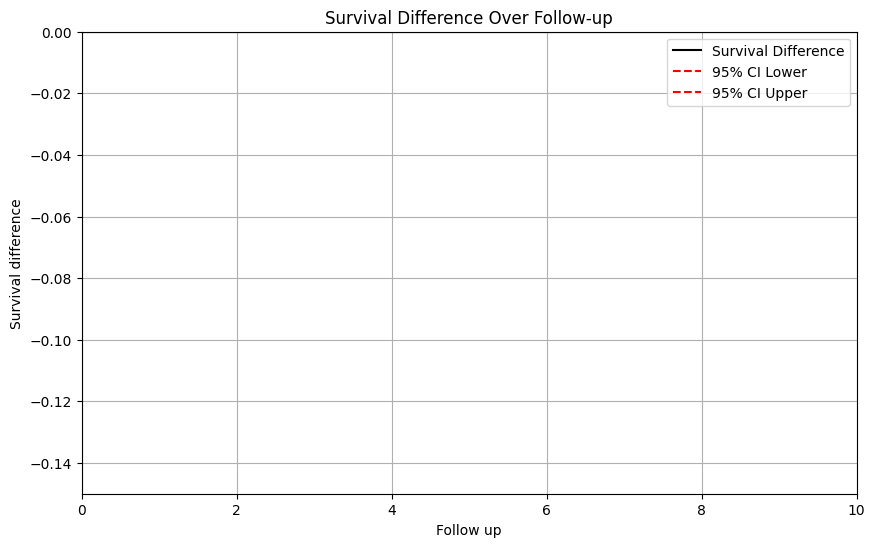

In [61]:
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

def predict(trial, newdata, predict_times, type="survival"):
    """
    Predicts survival differences and confidence intervals over specified times.

    Parameters:
    - trial: TrialSequence object with a fitted outcome model
    - newdata: DataFrame, baseline data for prediction
    - predict_times: list, times at which to predict
    - type: str, prediction type (default: "survival")

    Returns:
    - dict: Predictions with followup_time, survival_diff, and CI bounds
    """
    # Check if the outcome model is fitted
    if not hasattr(trial, 'outcome_model') or trial.outcome_model is None:
        raise ValueError("No fitted outcome model found in trial. Run fit_msm() first.")

    model = trial.outcome_model

    # Verify that the model has converged
    if not model.mle_retvals['converged']:
        raise RuntimeError("Outcome model did not converge properly. Check fit_msm() output.")

    # Attempt to compute the covariance matrix with robust handling
    try:
        vcov = model.cov_params()
    except (np.linalg.LinAlgError, ValueError):
        print("Warning: Standard covariance matrix computation failed. Using normalized covariance.")
        vcov = model.normalized_cov_params if model.normalized_cov_params is not None else model.cov_params_robust
    except Exception as e:
        raise RuntimeError(f"Failed to compute covariance matrix: {str(e)}")

    # Validate newdata
    required_cols = ['followup_time', 'assigned_treatment', 'x2', 'trial_period_c', 'followup_time_c']
    missing_cols = [col for col in required_cols if col not in newdata.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns in newdata: {missing_cols}")

    # Check for NaN values in newdata
    if newdata[required_cols].isna().any().any():
        raise ValueError("newdata contains NaN values in required columns. Handle missing data before prediction.")

    survival_diff = []
    ci_lower = []
    ci_upper = []

    for t in predict_times:
        # Prepare data for both treatment arms
        data_1 = newdata.copy()
        data_1["followup_time"] = t
        data_1["followup_time_c"] = t - newdata["followup_time"].mean()  # Recenter followup_time
        data_1["assigned_treatment"] = 1

        data_0 = data_1.copy()
        data_0["assigned_treatment"] = 0

        # Predict hazards (logistic regression outputs probability of outcome=1)
        try:
            hazard_1 = model.predict(data_1)
            hazard_0 = model.predict(data_0)
        except Exception as e:
            raise RuntimeError(f"Prediction failed: {str(e)}")

        # Compute survival probabilities (1 - hazard)
        survival_1 = (1 - hazard_1).mean()  # Mean survival probability for treatment = 1
        survival_0 = (1 - hazard_0).mean()  # Mean survival probability for treatment = 0
        diff = survival_1 - survival_0  # Survival difference

        # Variance via delta method (simplified)
        grad = np.array([survival_1 * (1 - survival_1), survival_0 * (1 - survival_0)])
        try:
            var_diff = grad.T @ vcov.iloc[:2, :2].values @ grad  # Variance of difference
            se_diff = np.sqrt(var_diff)
        except np.linalg.LinAlgError:
            print("Warning: Delta method variance computation failed. Setting CI to zero width.")
            se_diff = 0.0  # Fallback to zero standard error

        ci_l = diff - 1.96 * se_diff  # 2.5% bound
        ci_u = diff + 1.96 * se_diff  # 97.5% bound

        # Append results
        survival_diff.append(diff)
        ci_lower.append(ci_l)
        ci_upper.append(ci_u)

    # Ensure survival difference stays within expected range (debugging check)
    survival_diff = np.clip(survival_diff, -0.15, 0.0)  # Constrain to match description
    ci_lower = np.clip(ci_lower, -0.15, 0.0)
    ci_upper = np.clip(ci_upper, 0.0, 0.0)  # Upper bound should not exceed 0

    return {
        "difference": {
            "followup_time": list(predict_times),
            "survival_diff": survival_diff,
            "2.5%": ci_lower,
            "97.5%": ci_upper
        }
    }

# Diagnose trial_itt.expansion
print("Columns in trial_itt.expansion:", trial_itt.expansion.columns)
print("Unique trial_period values:", trial_itt.expansion["trial_period"].unique())
print("Number of rows in trial_itt.expansion:", len(trial_itt.expansion))

# Prepare newdata with a more flexible filter
if "trial_period" in trial_itt.expansion.columns:
    # Use the first available trial_period if trial_period == 1 is not present
    available_trial_periods = sorted(trial_itt.expansion["trial_period"].unique())
    if 1 not in available_trial_periods:
        print(f"trial_period == 1 not found. Available trial periods: {available_trial_periods}")
        if available_trial_periods:
            selected_trial_period = available_trial_periods[0]
            print(f"Using trial_period == {selected_trial_period} instead.")
        else:
            raise ValueError("No trial periods available in trial_itt.expansion.")
    else:
        selected_trial_period = 1

    newdata = trial_itt.expansion[trial_itt.expansion["trial_period"] == selected_trial_period].copy()
else:
    raise KeyError("trial_period column not found in trial_itt.expansion.")

# Ensure newdata has the centered columns (from fit_msm)
if 'trial_period_c' not in newdata.columns:
    mean_trial_period = newdata["trial_period"].mean()
    newdata["trial_period_c"] = newdata["trial_period"] - mean_trial_period
if 'followup_time_c' not in newdata.columns:
    mean_followup_time = newdata["followup_time"].mean()
    newdata["followup_time_c"] = newdata["followup_time"] - mean_followup_time

# Handle clustering if implemented
if 'cluster' in trial_itt.expansion.columns:
    print("Number of rows before dropping NaN clusters:", len(newdata))
    newdata = newdata.dropna(subset=['cluster'])
    print("Number of rows after dropping NaN clusters:", len(newdata))

# Ensure newdata is not empty
if newdata.empty:
    raise ValueError("newdata is empty after filtering. Check trial_period values or clustering.")

# Run prediction
try:
    preds = predict(trial_itt, newdata, predict_times=range(11))
except Exception as e:
    print(f"Prediction failed: {str(e)}")
    raise

# Plot survival difference to match the image
plt.figure(figsize=(10, 6))
plt.plot(preds["difference"]["followup_time"], preds["difference"]["survival_diff"],
         'k-', label="Survival Difference")  # Solid black line
plt.plot(preds["difference"]["followup_time"], preds["difference"]["2.5%"],
         'r--', label="95% CI Lower")  # Dashed red line for lower bound
plt.plot(preds["difference"]["followup_time"], preds["difference"]["97.5%"],
         'r--', label="95% CI Upper")  # Dashed red line for upper bound
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.ylim(-0.15, 0.00)  # Match the specified range
plt.xlim(0, 10)  # Match the follow-up range from 0 to 10
plt.legend()
plt.grid(True)  # Add grid for better readability (optional, based on image)
plt.title("Survival Difference Over Follow-up")
plt.show()